# Berlin Air Quality

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import h3
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar # https://aeturrell.github.io/coding-for-economists/geo-vis.html
import contextily as cx # to retrieve tile maps from the internet


In [3]:
magnitudes = ["co", "pm10", "pm2.5", "no2", "o3"] # to be used
markers = ["s", "o", "^", "v", "<", "*", "."]
colors = ["red", "yellow", "brown", "orange", "blue", "magenta", "cyan"]
months = 12

In [4]:
# Access to station locations: https://luftdaten.berlin.de/pollution/pm10?stationgroup=all&period=1h&timespan=custom&start%5Bdate%5D=01.12.2022&start%5Bhour%5D=00&end%5Bdate%5D=01.01.2023&end%5Bhour%5D=00, click on station name in the table column >> station info >> mehr info 

locations_recht = { # UTM coordinates (WGS84)), rechtswert
    '010 Wedding': 388062,
    '014 Sondermessstation': 383544,
    '018 Schöneberg': 387851,
    '027 Marienfelde': 388930,
    '032 Grunewald': 379436,
    '042 Neukölln': 393459,
    '077 Buch': 397243,
    '085 Friedrichshagen': 408051,
    '115 Hardenbergplatz': 386851,
    '117 Schildhornstraße': 385746,
    '124 Mariendorfer Damm': 390406,
    '143 Silbersteinstraße': 394135,
    '145 Frohnau': 384814,
    '171 Mitte': 392700,
    '174 Frankfurter Allee': 396183,
    '190 Leipziger Straße':  390219,
    '221 Karl-Marx-Straße': 393907,
    '282 Karlshorst': 400148
}

locations_hoch = { # UTM coordinates (WGS84)), hochwert
    '010 Wedding': 5822699,
    '014 Sondermessstation': 5819872,
    '018 Schöneberg': 5816333,
    '027 Marienfelde': 5806550,
    '032 Grunewald': 5815139,
    '042 Neukölln': 5816635,
    '077 Buch': 5833612,
    '085 Friedrichshagen': 5811940,
    '115 Hardenbergplatz': 5818686,
    '117 Schildhornstraße': 5813933,
    '124 Mariendorfer Damm': 5810992,
    '143 Silbersteinstraße': 5814179,
    '145 Frohnau': 5834983,
    '171 Mitte': 5819341,
    '174 Frankfurter Allee': 5819313,
    '190 Leipziger Straße': 5818973,
    '221 Karl-Marx-Straße': 5815453,
    '282 Karlshorst': 5816043
}

locations = { # UTM coordinates (WGS84))
    '010 Wedding': [388062, 5822699], # Rechtswert, Hochwert
    '014 Sondermessstation': [383544, 5819872],
    '018 Schöneberg': [387851, 5816333],
    '027 Marienfelde': [388930, 5806550],
    '032 Grunewald': [379436, 5815139],
    '042 Neukölln': [393459, 5816635],
    '077 Buch': [397243, 5833612],
    '085 Friedrichshagen': [408051, 5811940],
    '115 Hardenbergplatz': [386851, 5818686],
    '117 Schildhornstraße': [385746, 5813933],
    '124 Mariendorfer Damm': [390406, 5810992],
    '143 Silbersteinstraße': [394135, 5814179],
    '145 Frohnau': [384814, 5834983],
    '171 Mitte': [392700, 5819341],
    '174 Frankfurter Allee': [396183, 5819313],
    '190 Leipziger Straße':  [390219, 5818973],
    '221 Karl-Marx-Straße': [393907, 5815453],
    '282 Karlshorst': [400148, 5816043]
}

In [5]:
raw_df = { }

for magnitude in magnitudes:
    for month in range(1, months+1, 1): # concatenate all months
        if month == 1:
            raw_df[magnitude] = pd.read_csv('./../cgarrido/berlin_data/air_pollution/ber_' + str(magnitude) + '_month' + str(month) + '.csv', sep=';')
            raw_df[magnitude] = raw_df[magnitude][3:] 
            raw_df[magnitude] = raw_df[magnitude].sort_values(by='Station')
            raw_df[magnitude] = raw_df[magnitude].reset_index(drop=True)
        else:
            aux_df = pd.read_csv('./../cgarrido/berlin_data/air_pollution/ber_' + str(magnitude) + '_month' + str(month) + '.csv', sep=';')
            aux_df = aux_df[3:] 
            aux_df = aux_df.sort_values(by='Station')
            aux_df = aux_df.reset_index(drop=True)
            #raw_df[magnitude] = pd.concat([aux_df, raw_df[magnitude].loc[:]]).reset_index(drop = True)
            raw_df[magnitude] = pd.concat([aux_df, raw_df[magnitude]]).reset_index(drop = True)
    #print(pd.read_pickle('madrid_data/traffic/' + f'gdf_raw_traffic_month_{month}' + ".pkl").shape[0])
            


In [6]:
test_df = pd.read_csv('./../cgarrido/berlin_data/air_pollution/ber_' + str('co') + '_month' + str(1) + '.csv', sep=';')

In [7]:
test_df_2 = pd.read_csv('./../cgarrido/berlin_data/air_pollution/ber_' + str('no2') + '_month' + str(2) + '.csv', sep=';')

In [8]:
test_df

,Station,117 Schildhornstraße,174 Frankfurter Allee
0,Messkomponente,Kohlenmonoxid,Kohlenmonoxid
1,Einheit,mg/m³,mg/m³
2,Messzeit (Angaben in MESZ bzw. MEZ),Stundenwerte,Stundenwerte
3,01.01.2022 00:00,0.2,0.2
4,01.01.2022 01:00,0.3,0.3
...,...,...,...
743,31.01.2022 20:00,0.3,0.3
744,31.01.2022 21:00,0.3,0.3
745,31.01.2022 22:00,0.3,0.3
746,31.01.2022 23:00,0.3,0.3


In [9]:
raw_df['co']

,Station,117 Schildhornstraße,174 Frankfurter Allee
0,01.12.2022 01:00,0.3,0.4
1,01.12.2022 02:00,0.3,0.4
2,01.12.2022 03:00,0.3,0.4
3,01.12.2022 04:00,0.3,0.4
4,01.12.2022 05:00,0.3,0.4
...,...,...,...
8754,31.01.2022 19:00,0.3,0.3
8755,31.01.2022 20:00,0.3,0.3
8756,31.01.2022 21:00,0.3,0.3
8757,31.01.2022 22:00,0.3,0.3


In [10]:
# Add columns with sensor locationsd as new rows:
for magnitude in magnitudes:
    raw_df[magnitude] = pd.melt(raw_df[magnitude], id_vars='Station', var_name='station_id', value_name='intensity')
    raw_df[magnitude].rename(columns = {'Station': 'datetime'}, inplace = True)

In [11]:
raw_df['no2']['date'] = raw_df['no2']['datetime'].apply(lambda x : datetime.datetime.strptime(x, "%d.%m.%Y %H:%M"))
#'01.01.2022 00:00'

In [12]:
raw_df['no2']['date'] = raw_df['no2']['date'].apply(lambda x : x.date())


In [13]:
raw_df['no2']['date'].unique()

array([datetime.date(2022, 12, 1), datetime.date(2022, 12, 2),
       datetime.date(2022, 12, 3), datetime.date(2022, 12, 4),
       datetime.date(2022, 12, 5), datetime.date(2022, 12, 6),
       datetime.date(2022, 12, 7), datetime.date(2022, 12, 8),
       datetime.date(2022, 12, 9), datetime.date(2022, 12, 10),
       datetime.date(2022, 12, 11), datetime.date(2022, 12, 12),
       datetime.date(2022, 12, 13), datetime.date(2022, 12, 14),
       datetime.date(2022, 12, 15), datetime.date(2022, 12, 16),
       datetime.date(2022, 12, 17), datetime.date(2022, 12, 18),
       datetime.date(2022, 12, 19), datetime.date(2022, 12, 20),
       datetime.date(2022, 12, 21), datetime.date(2022, 12, 22),
       datetime.date(2022, 12, 23), datetime.date(2022, 12, 24),
       datetime.date(2022, 12, 25), datetime.date(2022, 12, 26),
       datetime.date(2022, 12, 27), datetime.date(2022, 12, 28),
       datetime.date(2022, 12, 29), datetime.date(2022, 12, 30),
       datetime.date(2022, 12, 31)

In [14]:
for magnitude in magnitudes:
    raw_df[magnitude]['recht'] = raw_df[magnitude][['station_id']].replace(locations_recht)
    raw_df[magnitude]['hoch'] = raw_df[magnitude][['station_id']].replace(locations_hoch)

In [15]:
raw_df['co']

,datetime,station_id,intensity,recht,hoch
0,01.12.2022 01:00,117 Schildhornstraße,0.3,385746,5813933
1,01.12.2022 02:00,117 Schildhornstraße,0.3,385746,5813933
2,01.12.2022 03:00,117 Schildhornstraße,0.3,385746,5813933
3,01.12.2022 04:00,117 Schildhornstraße,0.3,385746,5813933
4,01.12.2022 05:00,117 Schildhornstraße,0.3,385746,5813933
...,...,...,...,...,...
17513,31.01.2022 19:00,174 Frankfurter Allee,0.3,396183,5819313
17514,31.01.2022 20:00,174 Frankfurter Allee,0.3,396183,5819313
17515,31.01.2022 21:00,174 Frankfurter Allee,0.3,396183,5819313
17516,31.01.2022 22:00,174 Frankfurter Allee,0.3,396183,5819313


In [16]:
raw_df[magnitude]

,datetime,station_id,intensity,recht,hoch
0,01.12.2022 01:00,010 Wedding,15,388062,5822699
1,01.12.2022 02:00,010 Wedding,14,388062,5822699
2,01.12.2022 03:00,010 Wedding,8,388062,5822699
3,01.12.2022 04:00,010 Wedding,9,388062,5822699
4,01.12.2022 05:00,010 Wedding,11,388062,5822699
...,...,...,...,...,...
78826,31.01.2022 19:00,174 Frankfurter Allee,42,396183,5819313
78827,31.01.2022 20:00,174 Frankfurter Allee,34,396183,5819313
78828,31.01.2022 21:00,174 Frankfurter Allee,30,396183,5819313
78829,31.01.2022 22:00,174 Frankfurter Allee,38,396183,5819313


In [17]:
gpd_df = { }

for magnitude in magnitudes:
    s = gpd.GeoSeries([Point(x,y) for x, y in zip(raw_df[magnitude]['recht'], raw_df[magnitude]['hoch'])])
    gpd_df[magnitude] = gpd.GeoDataFrame(raw_df[magnitude], geometry=s, crs='epsg:25833')
    #gpd_df[magnitude] = gpd_df[magnitude].to_crs(epsg=3857)

In [18]:
gpd_df['co']

,datetime,station_id,intensity,recht,hoch,geometry
0,01.12.2022 01:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
1,01.12.2022 02:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
2,01.12.2022 03:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
3,01.12.2022 04:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
4,01.12.2022 05:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
...,...,...,...,...,...,...
17513,31.01.2022 19:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)
17514,31.01.2022 20:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)
17515,31.01.2022 21:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)
17516,31.01.2022 22:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)


In [19]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326") # transform geometry to lat/lon
transformer = Transformer.from_crs('EPSG:25833', 'EPSG:4326', always_xy=True)
import math

def convert_to_lat_lon(x, y, stn_id):
    if math.isnan(x):
        return transformer.transform(locations[stn_id][0], locations[stn_id][1])
    else :
        return transformer.transform(x, y)
        

In [20]:


for magnitude in magnitudes:
    
    poly = gpd_df[magnitude]['geometry']
    
    #gpd_df[magnitude]['datetime'] = gpd_df[magnitude]['datetime'].str.replace('.','-', regex=False)
    gpd_df[magnitude] = gpd_df[magnitude].rename(columns = {'intensity': magnitude})
    gpd_df[magnitude] = gpd_df[magnitude].to_crs(epsg=3857)
    gpd_df[magnitude]['longitude'], gpd_df[magnitude]['latitude'] = transformer.transform(poly.centroid.x, poly.centroid.y)
    gpd_df[magnitude] = gpd_df[magnitude].drop(columns = ['recht', 'hoch'])
    
    #gpd_df[magnitude] =  gpd_df[magnitude].to_crs(epsg=3857) 
    
## Convertir las coordenadas al CRS de destino
#longitud, latitud = transformador.transform(x, y)

In [21]:
raw_df['co']

,datetime,station_id,intensity,recht,hoch,geometry
0,01.12.2022 01:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
1,01.12.2022 02:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
2,01.12.2022 03:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
3,01.12.2022 04:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
4,01.12.2022 05:00,117 Schildhornstraße,0.3,385746,5813933,POINT (385746.000 5813933.000)
...,...,...,...,...,...,...
17513,31.01.2022 19:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)
17514,31.01.2022 20:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)
17515,31.01.2022 21:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)
17516,31.01.2022 22:00,174 Frankfurter Allee,0.3,396183,5819313,POINT (396183.000 5819313.000)


In [22]:
for magnitude in magnitudes:
    gpd_df[magnitude].to_pickle("./../cgarrido/berlin_data/air_pollution/" + f'gdf_raw_{magnitude}' + ".pkl")

KeyboardInterrupt: 

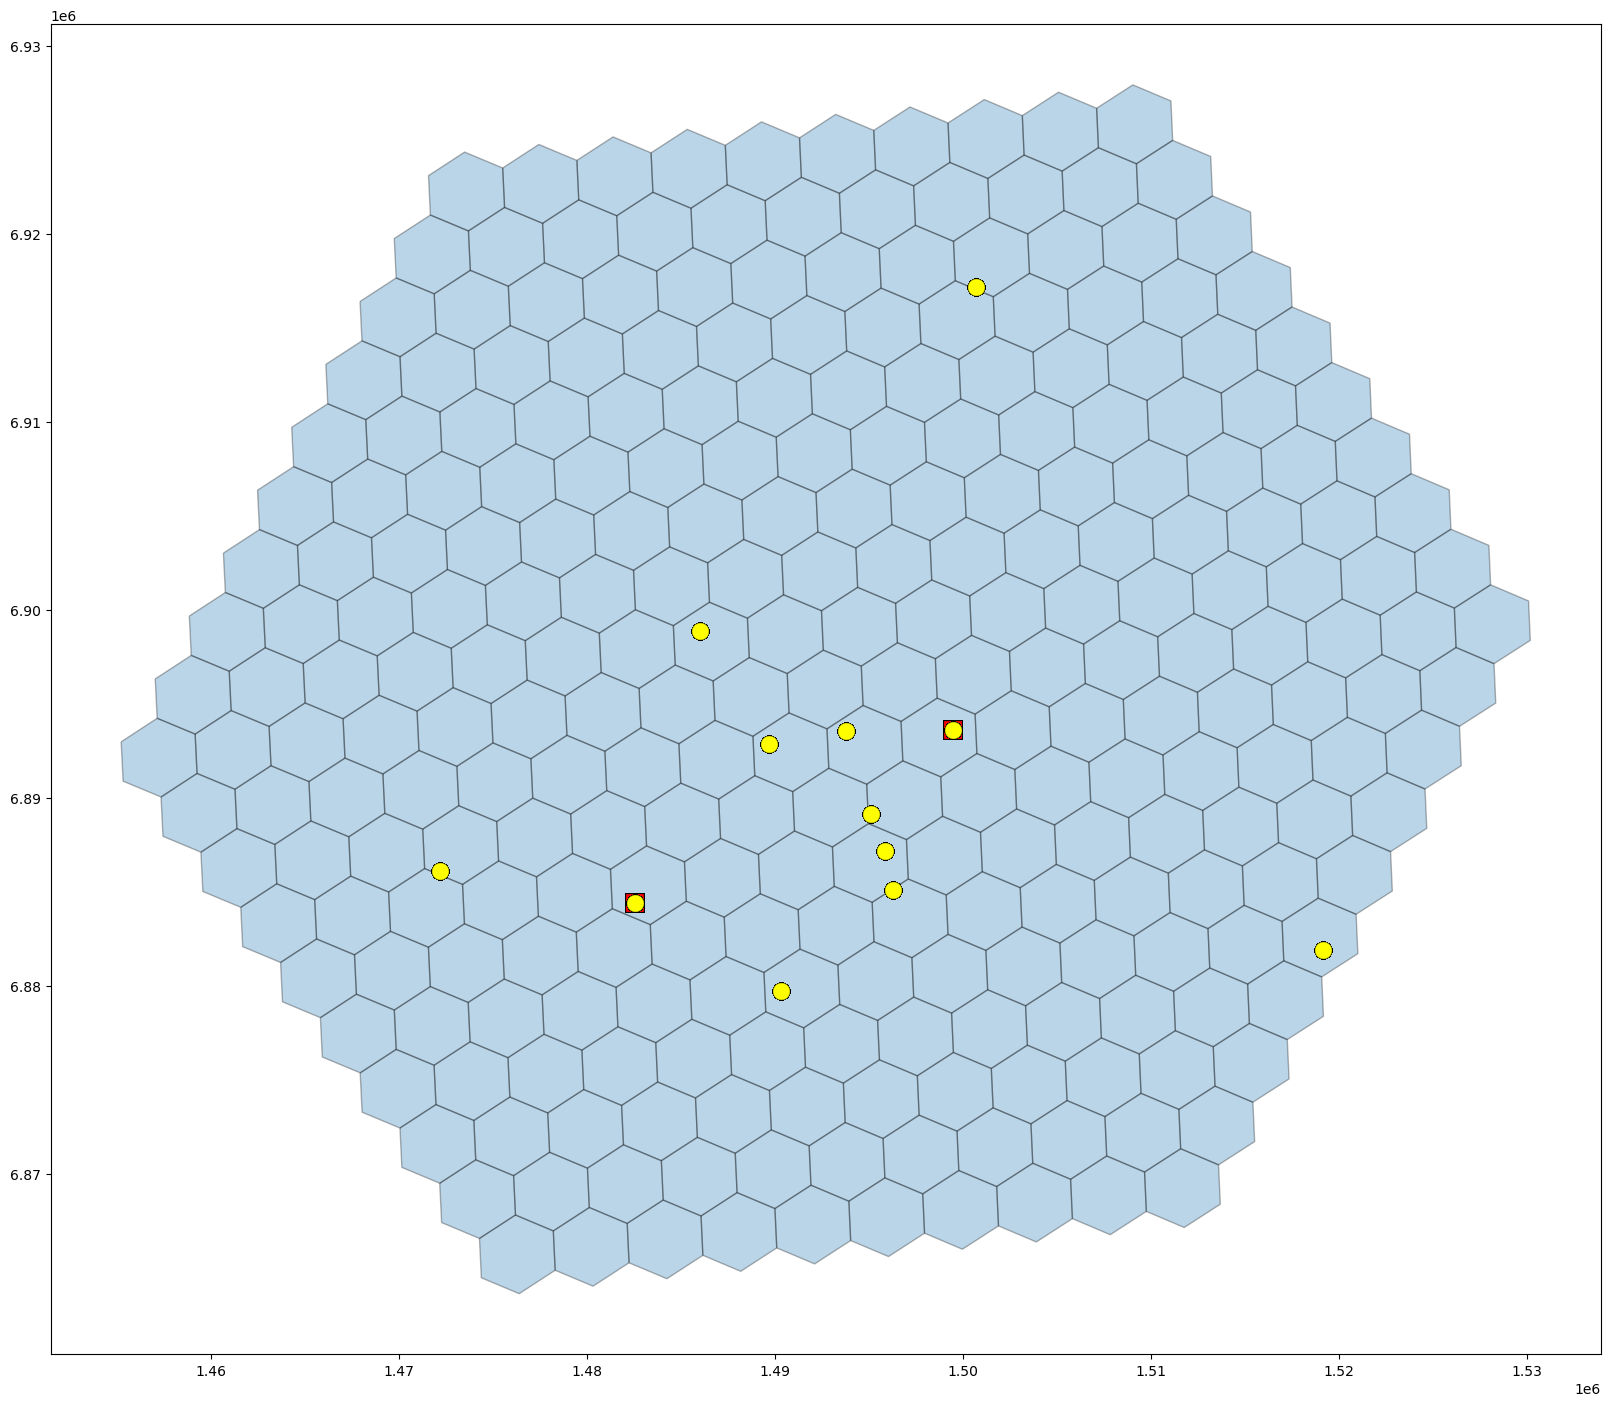

In [23]:
hexagons_gdf = pd.read_pickle('./../cgarrido/berlin_data/hex_grid/hexagons.pkl')

f, ax = plt.subplots(figsize=(20, 20))
hexagons_gdf.plot(alpha=0.3, edgecolor='k', ax=ax)
for idx, magnitude in enumerate(magnitudes):
    gpd_df[magnitude].to_crs(epsg=3857).plot(marker = markers[idx], color = colors[idx], edgecolor = "black", alpha=0.7, linewidth=0.2, markersize=150, ax=ax, label=(magnitudes[idx]).upper())

ax.legend()

for hex in hexagons_gdf['hexagon_id']:
    print(hex)
    s = "{} ({},{})".format(hex, int(hexagons_gdf[hexagons_gdf['hexagon_id'] == hex]['hexagon_x']), int(hexagons_gdf[hexagons_gdf['hexagon_id'] == hex]['hexagon_y']))
    ax.text(x = hexagons_gdf[hexagons_gdf['hexagon_id'] == hex]['geometry'].centroid.x - 650,
            y = hexagons_gdf[hexagons_gdf['hexagon_id'] == hex]['geometry'].centroid.y,
            s = s,
            fontsize = 8, color = 'black', weight = 'bold')

scalebar = ScaleBar(1, box_alpha=0, location="lower right", length_fraction=0.25, font_properties={"size": 12})

ax.add_artist(scalebar)
cx.add_basemap(ax)
ax.set_ylabel("Y coordinate")
ax.set_xlabel("X coordinate")
ax.set_title("Berlin's air quality stations (WGS 84 - EPSG:3857)")

#WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS

In [ ]:
f.savefig('results/air_quality_stations_berlin2.png')

In [24]:
gpd_df['co']

,datetime,station_id,co,geometry,longitude,latitude
0,01.12.2022 01:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600
1,01.12.2022 02:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600
2,01.12.2022 03:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600
3,01.12.2022 04:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600
4,01.12.2022 05:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600
...,...,...,...,...,...,...
17513,31.01.2022 19:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034
17514,31.01.2022 20:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034
17515,31.01.2022 21:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034
17516,31.01.2022 22:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034


In [25]:
resampling_interval = 15 # minutes
year = 2022

In [26]:
for magnitude in magnitudes:
    gpd_df[magnitude]['data'] = gpd_df[magnitude][magnitude]

In [27]:
proc_df = { }

for magnitude in magnitudes:
    
    if 'datetime' in gpd_df[magnitude].columns:
        gpd_df[magnitude] = gpd_df[magnitude].set_index('datetime')
        
    gpd_df[magnitude]['minute'] = np.zeros(len(gpd_df[magnitude].index))

    gpd_df[magnitude]['data'] = gpd_df[magnitude][magnitude]
    
    # Set datetime-based index and resample and fill with NaN new datetime rows
    gpd_df[magnitude].index = pd.to_datetime(gpd_df[magnitude].index)
    #gpd_df[magnitude] = gpd_df[magnitude].drop(columns = 'geometry')
    
    # Generate interpolated samples for data columns: 'intensity', 'occupation', 'load', 'avg_speed'
    interpolated_df = (gpd_df[magnitude].groupby(['station_id'], as_index= True)).resample(str(resampling_interval)+'T').interpolate('linear')
    #interpolated_df.reset_index(level = 1, inplace=True) # get the 'datetime' and set it to column
    #interpolated_df.drop(columns = ['station', 'longitude', 'latitude', 'altitude', 'type'], inplace = True) # drop 'id' column (will be taken from grouped index
    #interpolated_df.reset_index(level = 0, inplace=True) # get the 'id' from index and set it to column
    
    # Generate interpolated samples for data columns: 'intensity', 'occupation', 'load', 'avg_speed'
    interpolated_df['datetime'] = interpolated_df.index.get_level_values(1)
    interpolated_df = interpolated_df.reset_index(drop=True)  
    
    #last_df = (raw_df[magnitude].groupby(['station', 'longitude', 'latitude', 'altitude', 'type'], as_index= True)).resample(str(resampling_interval)+'T').last()
    #last_df['datetime'] = last_df.index.get_level_values(5)
    #last_df = last_df.reset_index(drop=True)  
    
    #interpolated_df.reset_index(level = 0, inplace=True) # get the 'id' from index and set it to column
    
    # Create new df:
    proc_weather = {
        "station_id": interpolated_df["station_id"].values.tolist(),
        "datetime": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()),
        "year": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()).year,
        "month": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()).month, 
        "day": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()).day, 
        "hour": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()).hour, 
        "minute": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()).minute, 
        "weekday": pd.DatetimeIndex(interpolated_df["datetime"].values.tolist()).weekday,
        #"station_type": interpolated_df["type"].values.tolist(), # assume same type
        "longitude": interpolated_df["longitude"].values.tolist(),
        "latitude": interpolated_df["latitude"].values.tolist(),
        "altitude": interpolated_df["altitude"].values.tolist(),
        "data": interpolated_df.data
        } # create magnitude dfs to store processed data
    
    proc_df[magnitude] = pd.DataFrame(proc_weather).reset_index(drop=True).fillna(method='ffill')
    proc_df[magnitude] = proc_df[magnitude].sort_values(by='datetime')
    
    for item in proc_df[magnitude]['station_id'].unique(): # add manually 23:15, 23:30 and 23:45 of 31st December (no next value to interpolate) [Hurdle#3]
        for minute in range(resampling_interval, resampling_interval*int(60/resampling_interval), resampling_interval):

            mask = proc_df[magnitude][proc_df[magnitude]['station_id'] == item]
            
            new_df = proc_df[magnitude][proc_df[magnitude]['station_id'] == item].tail(1).copy()
            new_df['year'] = int(year)
            new_df['month'] = 12
            new_df['day'] = 31
            new_df['hour'] = 23
            new_df['minute'] = minute
            new_df['weekday'] = datetime.datetime(int(year), 1, 1, 0, 0, 0).weekday()
            new_df['datetime'] = datetime.datetime(int(year), 12, 31, 23, minute, 0)
            new_df['longitude'] = mask['longitude'].tail(1)
            new_df['latitude'] = mask['latitude'].tail(1)
            new_df['altitude'] = mask['altitude'].tail(1)
            new_df['data'] = mask['data'].tail(1)            

            proc_df[magnitude] = pd.concat([proc_df[magnitude], new_df], axis=0, ignore_index = True) 
            proc_df[magnitude] = proc_df[magnitude].sort_values(by='datetime')

TypeError: interpolate() got an unexpected keyword argument 'method'

In [ ]:
!pip show pandas

In [28]:
#(gpd_df['co'].groupby(['station_id', 'longitude', 'latitude'], as_index= True)).resample(str(resampling_interval)+'T').count()
(gpd_df['co'].groupby(['station_id'], as_index= True)).resample(str(resampling_interval)+'T').mean()

gpd_df['pm10']

/tmp/ipykernel_476175/3334965932.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (gpd_df['co'].groupby(['station_id'], as_index= True)).resample(str(resampling_interval)+'T').mean()


,datetime,station_id,pm10,geometry,longitude,latitude,data
0,01.12.2022 01:00,010 Wedding,34,POINT (1486043.152 6898882.117),13.349353,52.542855,34
1,01.12.2022 02:00,010 Wedding,33,POINT (1486043.152 6898882.117),13.349353,52.542855,33
2,01.12.2022 03:00,010 Wedding,34,POINT (1486043.152 6898882.117),13.349353,52.542855,34
3,01.12.2022 04:00,010 Wedding,35,POINT (1486043.152 6898882.117),13.349353,52.542855,35
4,01.12.2022 05:00,010 Wedding,39,POINT (1486043.152 6898882.117),13.349353,52.542855,39
...,...,...,...,...,...,...,...
105103,31.01.2022 19:00,221 Karl-Marx-Straße,35,POINT (1495891.174 6887185.481),13.437819,52.478907,35
105104,31.01.2022 20:00,221 Karl-Marx-Straße,35,POINT (1495891.174 6887185.481),13.437819,52.478907,35
105105,31.01.2022 21:00,221 Karl-Marx-Straße,42,POINT (1495891.174 6887185.481),13.437819,52.478907,42
105106,31.01.2022 22:00,221 Karl-Marx-Straße,32,POINT (1495891.174 6887185.481),13.437819,52.478907,32


In [ ]:
gpd_df['co']

In [ ]:
#gpd_df['co'] = gpd_df['co'].reset_index()

In [ ]:
locations['117 Schildhornstraße']

In [ ]:
hexagons_gdf

In [29]:
gpd_df_with_hex = {}
for magnitude in magnitudes:
    gpd_df_with_hex[magnitude] = gpd.sjoin(gpd_df[magnitude], hexagons_gdf, how='left').drop(columns=['index_right'])
    gpd_df_with_hex[magnitude] = gpd_df_with_hex[magnitude].sort_values(by='datetime')
    gpd_df_with_hex[magnitude] = gpd_df_with_hex[magnitude].reset_index(drop=True)

In [ ]:
type(gpd_df)

In [30]:
gpd_df_with_hex['co']

,station_id,co,geometry,longitude,latitude,data,minute,hexagon_id,hexagon_x,hexagon_y,lat,lon
0,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,0.0,13,-2,-1,52.511793,13.463448
1,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,0.0,49,1,4,52.468799,13.324601
2,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600,0.3,0.0,49,1,4,52.468799,13.324601
3,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034,0.3,0.0,13,-2,-1,52.511793,13.463448
4,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,0.0,49,1,4,52.468799,13.324601
...,...,...,...,...,...,...,...,...,...,...,...,...
17513,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,0.0,13,-2,-1,52.511793,13.463448
17514,117 Schildhornstraße,0.1,POINT (1482578.185 6884388.306),13.318226,52.463600,0.1,0.0,49,1,4,52.468799,13.324601
17515,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,0.0,13,-2,-1,52.511793,13.463448
17516,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,0.0,49,1,4,52.468799,13.324601


In [243]:
for magnitude in magnitudes:
    gpd_df_with_hex[magnitude].to_pickle("./../cgarrido/berlin_data/air_pollution/" + f'gdf_with_hex_{magnitude}' + ".pkl")

In [209]:
!ls ./../cgarrido/berlin_data/air_pollution/

ber_CO_2022.csv      ber_no_month1.csv	   ber_pm10_month5.csv
ber_co_month10.csv   ber_no_month2.csv	   ber_pm10_month6.csv
ber_co_month11.csv   ber_no_month3.csv	   ber_pm10_month7.csv
ber_co_month12.csv   ber_no_month4.csv	   ber_pm10_month8.csv
ber_co_month1.csv    ber_no_month5.csv	   ber_pm10_month9.csv
ber_co_month2.csv    ber_no_month6.csv	   ber_PM2.5_2022.csv
ber_co_month3.csv    ber_no_month7.csv	   ber_pm2.5_month10.csv
ber_co_month4.csv    ber_no_month8.csv	   ber_pm2.5_month11.csv
ber_co_month5.csv    ber_no_month9.csv	   ber_pm2.5_month12.csv
ber_co_month6.csv    ber_O3_2022.csv	   ber_pm2.5_month1.csv
ber_co_month7.csv    ber_o3_month10.csv    ber_pm2.5_month2.csv
ber_co_month8.csv    ber_o3_month11.csv    ber_pm2.5_month3.csv
ber_co_month9.csv    ber_o3_month12.csv    ber_pm2.5_month4.csv
ber_NO_2022.csv      ber_o3_month1.csv	   ber_pm2.5_month5.csv
ber_NO2_2022.csv     ber_o3_month2.csv	   ber_pm2.5_month6.csv
ber_no2_month10.csv  ber_o3_month3.csv	   ber_pm2.5_month7

In [212]:
for magnitude in magnitudes:
    print(len(gpd_df_with_hex[magnitude]))

17518
105108
105108
157662
78831


In [215]:
 gpd_df_with_hex['pm10']

,datetime,station_id,pm10,geometry,longitude,latitude,hexagon_id,hexagon_x,hexagon_y,lat,lon
0,01.01.2022 00:00,077 Buch,9,POINT (1500730.879 6917185.795),13.481295,52.642739,147,1,-6,52.651207,13.488535
1,01.01.2022 00:00,032 Grunewald,12,POINT (1472195.462 6886120.669),13.224957,52.473080,111,4,6,52.480502,13.234906
2,01.01.2022 00:00,190 Leipziger Straße,15,POINT (1489719.398 6892835.849),13.382377,52.509810,2,0,1,52.507496,13.392682
3,01.01.2022 00:00,010 Wedding,22,POINT (1486043.152 6898882.117),13.349353,52.542855,10,2,1,52.539674,13.354664
4,01.01.2022 00:00,117 Schildhornstraße,21,POINT (1482578.185 6884388.306),13.318226,52.463600,49,1,4,52.468799,13.324601
...,...,...,...,...,...,...,...,...,...,...,...
105103,31.12.2022 23:00,077 Buch,14,POINT (1500730.879 6917185.795),13.481295,52.642739,147,1,-6,52.651207,13.488535
105104,31.12.2022 23:00,221 Karl-Marx-Straße,25,POINT (1495891.174 6887185.481),13.437819,52.478907,20,-2,1,52.475286,13.430667
105105,31.12.2022 23:00,010 Wedding,17,POINT (1486043.152 6898882.117),13.349353,52.542855,10,2,1,52.539674,13.354664
105106,31.12.2022 23:00,171 Mitte,35,POINT (1493774.044 6893531.107),13.418801,52.513611,5,-1,0,52.509650,13.428062


In [244]:
gpd_df_with_hex['co']

,datetime,station_id,co,geometry,longitude,latitude,data,hexagon_id,hexagon_x,hexagon_y,lat,lon
0,01.01.2022 00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601
1,01.01.2022 00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448
2,01.01.2022 01:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034,0.3,13,-2,-1,52.511793,13.463448
3,01.01.2022 01:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600,0.3,49,1,4,52.468799,13.324601
4,01.01.2022 02:00,174 Frankfurter Allee,0.4,POINT (1499486.390 6893608.456),13.470115,52.514034,0.4,13,-2,-1,52.511793,13.463448
...,...,...,...,...,...,...,...,...,...,...,...,...
17513,31.12.2022 21:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448
17514,31.12.2022 22:00,117 Schildhornstraße,0.1,POINT (1482578.185 6884388.306),13.318226,52.463600,0.1,49,1,4,52.468799,13.324601
17515,31.12.2022 22:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448
17516,31.12.2022 23:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601


In [248]:
for magnitude in magnitudes:
    gpd_df_with_hex[magnitude]['datetime'] = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y %H:%M'))
    gpd_df_with_hex[magnitude]['year']    = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x:x.year)
    gpd_df_with_hex[magnitude]['month']   = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x:x.month)
    gpd_df_with_hex[magnitude]['day']     = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x:x.day)
    gpd_df_with_hex[magnitude]['weekday'] = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x:x.weekday())
    gpd_df_with_hex[magnitude]['hour']    = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x:x.hour)
    gpd_df_with_hex[magnitude]['minute']  = gpd_df_with_hex[magnitude]['datetime'].apply(lambda x:x.minute)

In [249]:
gpd_df_with_hex['co']

,datetime,station_id,co,geometry,longitude,latitude,data,hexagon_id,hexagon_x,hexagon_y,lat,lon,year,month,day,weekday,hour,minute
0,2022-01-01 00:00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601,2022,1,1,5,0,0
1,2022-01-01 00:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,1,1,5,0,0
2,2022-01-01 01:00:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034,0.3,13,-2,-1,52.511793,13.463448,2022,1,1,5,1,0
3,2022-01-01 01:00:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600,0.3,49,1,4,52.468799,13.324601,2022,1,1,5,1,0
4,2022-01-01 02:00:00,174 Frankfurter Allee,0.4,POINT (1499486.390 6893608.456),13.470115,52.514034,0.4,13,-2,-1,52.511793,13.463448,2022,1,1,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17513,2022-12-31 21:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,12,31,5,21,0
17514,2022-12-31 22:00:00,117 Schildhornstraße,0.1,POINT (1482578.185 6884388.306),13.318226,52.463600,0.1,49,1,4,52.468799,13.324601,2022,12,31,5,22,0
17515,2022-12-31 22:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,12,31,5,22,0
17516,2022-12-31 23:00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601,2022,12,31,5,23,0


In [252]:
aggr_gdf = { }

for magnitude in magnitudes:
    aggr_gdf[f'{magnitude}'] = gpd_df_with_hex[f'{magnitude}'].copy()
    aggr_gdf[f'{magnitude}'][['data']] = (aggr_gdf[f'{magnitude}'].groupby(['hexagon_id', 'hexagon_x','hexagon_y', 'year', 'month', 'day', 'weekday', 'hour', 'minute'], as_index=False)[['data']]).transform('mean') # as_index param used to avoidt he keysused in groupby() becoming a new dataframe

aggr_gdf['co']

,datetime,station_id,co,geometry,longitude,latitude,data,hexagon_id,hexagon_x,hexagon_y,lat,lon,year,month,day,weekday,hour,minute
0,2022-01-01 00:00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601,2022,1,1,5,0,0
1,2022-01-01 00:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,1,1,5,0,0
2,2022-01-01 01:00:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034,0.3,13,-2,-1,52.511793,13.463448,2022,1,1,5,1,0
3,2022-01-01 01:00:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600,0.3,49,1,4,52.468799,13.324601,2022,1,1,5,1,0
4,2022-01-01 02:00:00,174 Frankfurter Allee,0.4,POINT (1499486.390 6893608.456),13.470115,52.514034,0.4,13,-2,-1,52.511793,13.463448,2022,1,1,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17513,2022-12-31 21:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,12,31,5,21,0
17514,2022-12-31 22:00:00,117 Schildhornstraße,0.1,POINT (1482578.185 6884388.306),13.318226,52.463600,0.1,49,1,4,52.468799,13.324601,2022,12,31,5,22,0
17515,2022-12-31 22:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,12,31,5,22,0
17516,2022-12-31 23:00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601,2022,12,31,5,23,0


In [253]:
gpd_df_with_hex['co']

,datetime,station_id,co,geometry,longitude,latitude,data,hexagon_id,hexagon_x,hexagon_y,lat,lon,year,month,day,weekday,hour,minute
0,2022-01-01 00:00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601,2022,1,1,5,0,0
1,2022-01-01 00:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,1,1,5,0,0
2,2022-01-01 01:00:00,174 Frankfurter Allee,0.3,POINT (1499486.390 6893608.456),13.470115,52.514034,0.3,13,-2,-1,52.511793,13.463448,2022,1,1,5,1,0
3,2022-01-01 01:00:00,117 Schildhornstraße,0.3,POINT (1482578.185 6884388.306),13.318226,52.463600,0.3,49,1,4,52.468799,13.324601,2022,1,1,5,1,0
4,2022-01-01 02:00:00,174 Frankfurter Allee,0.4,POINT (1499486.390 6893608.456),13.470115,52.514034,0.4,13,-2,-1,52.511793,13.463448,2022,1,1,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17513,2022-12-31 21:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,12,31,5,21,0
17514,2022-12-31 22:00:00,117 Schildhornstraße,0.1,POINT (1482578.185 6884388.306),13.318226,52.463600,0.1,49,1,4,52.468799,13.324601,2022,12,31,5,22,0
17515,2022-12-31 22:00:00,174 Frankfurter Allee,0.2,POINT (1499486.390 6893608.456),13.470115,52.514034,0.2,13,-2,-1,52.511793,13.463448,2022,12,31,5,22,0
17516,2022-12-31 23:00:00,117 Schildhornstraße,0.2,POINT (1482578.185 6884388.306),13.318226,52.463600,0.2,49,1,4,52.468799,13.324601,2022,12,31,5,23,0
